# Movielens 100k - Content-based RS Evaluation

For this evaluation precomputed Item-to-Item similarities were used. To generate required data, run "*movielens-cb.ipynb*" notebook.

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.errors import SettingWithCopyWarning
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [5]:
df = pd.read_csv("ml-latest-small/ratings.csv", sep=",")
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [6]:
moviesDF = pd.read_csv("ml-latest-small/movies.csv", sep=",")
moviesDF.movieId = moviesDF.movieId.astype(int)
moviesDF.set_index("movieId", inplace=True)

# Extract years
moviesDF["year"] = moviesDF.title.str.extract(r'\(([0-9]+)\)')
moviesDF["year"] = moviesDF.year.astype("float")

# Clean title
moviesDF["title"] = moviesDF.title.str.replace(r'\(([0-9]+)\)$', "").str.strip()

# Clean genres
moviesDF["genres"] = moviesDF.genres.str.lower()

moviesDF

,title,genres,year
movieId,,,
1,Toy Story,adventure|animation|children|comedy|fantasy,1995.0
2,Jumanji,adventure|children|fantasy,1995.0
3,Grumpier Old Men,comedy|romance,1995.0
4,Waiting to Exhale,comedy|drama|romance,1995.0
5,Father of the Bride Part II,comedy,1995.0
...,...,...,...
193581,Black Butler: Book of the Atlantic,action|animation|comedy|fantasy,2017.0
193583,No Game No Life: Zero,animation|comedy|fantasy,2017.0
193585,Flint,drama,2017.0


In [7]:
df["title"] = moviesDF.title.loc[df.movieId].values
df.drop(columns=["timestamp"], inplace=True)

Let's use ratings by people, that have more than 20 ratings total for evaluation.

In [8]:
ratingCounts = df.groupby("movieId")["userId"].count()
valid_items = ratingCounts.loc[ratingCounts >= 20].index.values
df = df.loc[df.movieId.isin(valid_items)]
df

,userId,movieId,rating,title
0,1,1,4.0,Toy Story
1,1,3,4.0,Grumpier Old Men
2,1,6,4.0,Heat
3,1,47,5.0,Seven (a.k.a. Se7en)
4,1,50,5.0,"Usual Suspects, The"
...,...,...,...,...
100803,610,148626,4.0,"Big Short, The"
100808,610,152081,4.0,Zootopia
100829,610,164179,5.0,Arrival
100830,610,166528,4.0,Rogue One: A Star Wars Story


<AxesSubplot: >

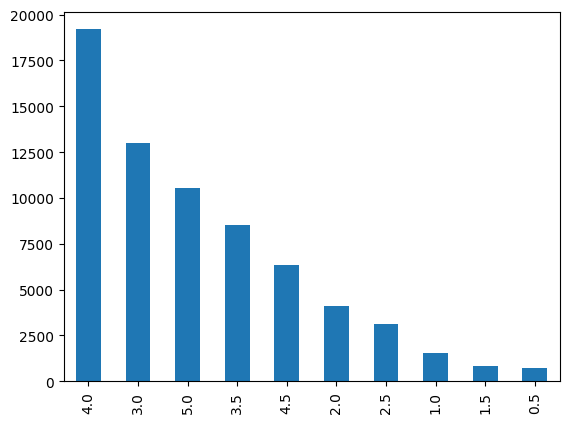

In [9]:
df.rating.value_counts().plot(kind = "bar")

### Mapping users and items

In [10]:
map_users = {user: u_id for u_id, user in enumerate(df.userId.unique())}
map_items = {item: i_id for i_id, item in enumerate(df.movieId.unique())}

df["movieId"] = df["movieId"].map(map_items)
df["userId"] = df["userId"].map(map_users)

In [11]:
df.head()

,userId,movieId,rating,title
0,0,0,4.0,Toy Story
1,0,1,4.0,Grumpier Old Men
2,0,2,4.0,Heat
3,0,3,5.0,Seven (a.k.a. Se7en)
4,0,4,5.0,"Usual Suspects, The"


### Creating inverse mappings for future recommendations

In [12]:
movieId_title = {}
for idx, row in df.iterrows():
    movieId_title[row["movieId"]] = row["title"]
    
np.save("mappings/map_title.npy", movieId_title)
    
movieId_genres = pd.Series(moviesDF.genres, index = moviesDF.index)
    
np.save("mappings/map_genres.npy", movieId_genres)

movieId_tags = pd.Series(np.load("mappings/map_tags.npy", allow_pickle=True))

### Split User-Item Dataset 

In [13]:
# Using randomized (0.33 * df.size) for testing and the rest (0.67 * df.size) for training
train, test = train_test_split(df, test_size = 0.33, random_state = 56)
train.to_csv("train.dat", index=False, header=False, sep="\t", encoding="CP1250", errors="ignore")
test.to_csv("test.dat", index=False, header=False, sep="\t", encoding="CP1250", errors="ignore")

### Content-based similarities preprocessing

In [14]:
unique_movie_ids = pd.concat([train, test]).movieId.unique()
unique_movie_ids.shape

(1297,)

In [15]:
# Preprocessing precomputed metadata_files (similarity files) to only include movies rated by some people (which we are observing)
def preprocess_metadata(metadata_file):
    metadata = pd.read_csv(metadata_file, sep="\t", encoding="CP1250", header=None, names=["item1", "item2", "rel"])
    filtered = metadata.loc[metadata["item1"].isin(unique_movie_ids) & metadata["item2"].isin(unique_movie_ids)]
    filtered.to_csv(f"processed/{metadata_file}", index=False, header=False, sep="\t", encoding="CP1250", errors="ignore")

In [16]:
preprocess_metadata("title_sim.dat")
preprocess_metadata("tag_sim.dat")
preprocess_metadata("genre_sim.dat")
preprocess_metadata("title_tag_sim.dat")
preprocess_metadata("title_genre_sim.dat")

### Train and evaluate

Using *caserec* RS library we evaluate CB RecSys using real ratings made by users in testing data. If the item recommended to the user is seen by the user in testing data, we think of it as relevant.

In [17]:
from caserec.recommenders.item_recommendation.content_based import ContentBased

# Top-N recommendations
RANK_LENGTH = 50
# Optional metrics used for evaluation: ["PREC", "RECALL", "NDCG", "MAP"]
METRICS = ["PREC", "RECALL", "NDCG", "MAP"]
# For which ranks we evaluate metrics
RANK_EVAL = [10, 20, 50]

Title similarity

In [18]:
title_model = ContentBased("train.dat", "test.dat", similarity_file="processed/title_sim.dat", 
                             output_file="output/rank_title.dat", as_binary=False, rank_length=RANK_LENGTH)
title_model.compute(as_table=True, table_sep="\t", metrics=METRICS, n_ranks=RANK_EVAL)

[Case Recommender: Item Recommendation > Content Based Algorithm]

train data:: 610 users and 1297 items (45491 interactions) | sparsity:: 94.25%
test data:: 610 users and 1297 items (22407 interactions) | sparsity:: 97.17%

training_time:: 0.007982 sec
prediction_time:: 22.567967 sec


PREC@10	PREC@20	PREC@50	RECALL@10	RECALL@20	RECALL@50	NDCG@10	NDCG@20	NDCG@50	MAP@10	MAP@20	MAP@50	
0.06623	0.085656	0.081607	0.023463	0.063036	0.128316	0.216975	0.258815	0.291939	0.132644	0.136731	0.133862	


Tags similarity

In [19]:
tag_model = ContentBased("train.dat", "test.dat", similarity_file="processed/tag_sim.dat", 
                             output_file="output/rank_tag.dat", as_binary=False, rank_length=RANK_LENGTH)
tag_model.compute(as_table=True, table_sep="\t", metrics=METRICS, n_ranks=RANK_EVAL)

[Case Recommender: Item Recommendation > Content Based Algorithm]

train data:: 610 users and 1297 items (45491 interactions) | sparsity:: 94.25%
test data:: 610 users and 1297 items (22407 interactions) | sparsity:: 97.17%

training_time:: 0.010037 sec
prediction_time:: 22.910093 sec


PREC@10	PREC@20	PREC@50	RECALL@10	RECALL@20	RECALL@50	NDCG@10	NDCG@20	NDCG@50	MAP@10	MAP@20	MAP@50	
0.047869	0.047951	0.051934	0.013491	0.029481	0.094047	0.174812	0.213229	0.248201	0.117574	0.120592	0.100002	


Genre similarity

In [20]:
genre_model = ContentBased("train.dat", "test.dat", similarity_file="processed/genre_sim.dat", 
                             output_file="output/rank_genre.dat", as_binary=False, rank_length=RANK_LENGTH)
genre_model.compute(as_table=True, table_sep="\t", metrics=METRICS, n_ranks=RANK_EVAL)

[Case Recommender: Item Recommendation > Content Based Algorithm]

train data:: 610 users and 1297 items (45491 interactions) | sparsity:: 94.25%
test data:: 610 users and 1297 items (22407 interactions) | sparsity:: 97.17%

training_time:: 1.218894 sec
prediction_time:: 23.614394 sec


PREC@10	PREC@20	PREC@50	RECALL@10	RECALL@20	RECALL@50	NDCG@10	NDCG@20	NDCG@50	MAP@10	MAP@20	MAP@50	
0.055738	0.051885	0.041213	0.015075	0.027308	0.05433	0.216125	0.228107	0.245012	0.149846	0.140758	0.1212	


Combination of Title and Tag similarities

In [21]:
title_tag_model = ContentBased("train.dat", "test.dat", similarity_file="processed/title_tag_sim.dat", 
                             output_file="output/rank_title_tag.dat", as_binary=False, rank_length=RANK_LENGTH)
title_tag_model.compute(as_table=True, table_sep="\t", metrics=METRICS, n_ranks=RANK_EVAL)

[Case Recommender: Item Recommendation > Content Based Algorithm]

train data:: 610 users and 1297 items (45491 interactions) | sparsity:: 94.25%
test data:: 610 users and 1297 items (22407 interactions) | sparsity:: 97.17%

training_time:: 0.010617 sec
prediction_time:: 22.795777 sec


PREC@10	PREC@20	PREC@50	RECALL@10	RECALL@20	RECALL@50	NDCG@10	NDCG@20	NDCG@50	MAP@10	MAP@20	MAP@50	
0.047541	0.047295	0.050328	0.013271	0.028799	0.09214	0.174127	0.211382	0.246048	0.117886	0.11984	0.099411	


Combination of Title and Genre similarities

In [22]:
title_genre_model = ContentBased("train.dat", "test.dat", similarity_file="processed/title_genre_sim.dat", 
                             output_file="output/rank_title_genre.dat", as_binary=False, rank_length=RANK_LENGTH)
title_genre_model.compute(as_table=True, table_sep="\t", metrics=METRICS, n_ranks=RANK_EVAL)

[Case Recommender: Item Recommendation > Content Based Algorithm]

train data:: 610 users and 1297 items (45491 interactions) | sparsity:: 94.25%
test data:: 610 users and 1297 items (22407 interactions) | sparsity:: 97.17%

training_time:: 1.182623 sec
prediction_time:: 23.658360 sec


PREC@10	PREC@20	PREC@50	RECALL@10	RECALL@20	RECALL@50	NDCG@10	NDCG@20	NDCG@50	MAP@10	MAP@20	MAP@50	
0.055738	0.051885	0.04118	0.015075	0.027308	0.054002	0.216125	0.228098	0.244707	0.149027	0.139932	0.12034	


Some example of recommendation using title+genre variant:

In [23]:
ranking = pd.read_csv('output/rank_title_genre.dat', sep='\t', names=["userId", "movieId", "rating"])
ranking["title"] = ranking.movieId.map(movieId_title)
ranking["tags"] = ranking.movieId.map(movieId_tags)
ranking["genres"] = ranking.movieId.map(movieId_genres)
ranking.sort_values(by="rating", ascending=False).head(5)

,userId,movieId,rating,title,tags,genres
24900,498,917,0.585525,Entrapment,,children|drama
9696,193,412,0.582343,Multiplicity,assassination,drama
9684,193,334,0.582343,Sense and Sensibility,bus,drama
9670,193,254,0.582343,Strictly Ballroom,assassin jean reno hit men action assassin ass...,drama
9671,193,263,0.582343,Mars Attacks!,,drama


In [24]:
# Top-10 recommendation for User 1
ranking.loc[ranking.userId == 1].head(10)

,userId,movieId,rating,title,tags,genres
50,1,4,0.399869,"Usual Suspects, The",pregnancy remake,comedy|drama|romance
51,1,11,0.399869,Clerks,,comedy|drama|romance
52,1,52,0.399869,Reservoir Dogs,writing,comedy|drama|romance
53,1,58,0.399869,Star Wars: Episode V - The Empire Strikes Back,,comedy|drama|romance
54,1,94,0.399869,Wild Things,,comedy|drama|romance
55,1,195,0.399869,"Girl with the Dragon Tattoo, The",,comedy|drama|romance
56,1,224,0.399869,Heavenly Creatures,classic space action action sci fi epic great ...,comedy|drama|romance
57,1,232,0.399869,In the Name of the Father,,comedy|drama|romance
58,1,281,0.399869,Waking Ned Devine (a.k.a. Waking Ned),,comedy|drama|romance
59,1,351,0.399869,Crimson Tide,,comedy|drama|romance


## Summary

Based on the above 4 variants of using title, tag, genre, title+tag and title+genre for Content-based recommendation, these are the results:

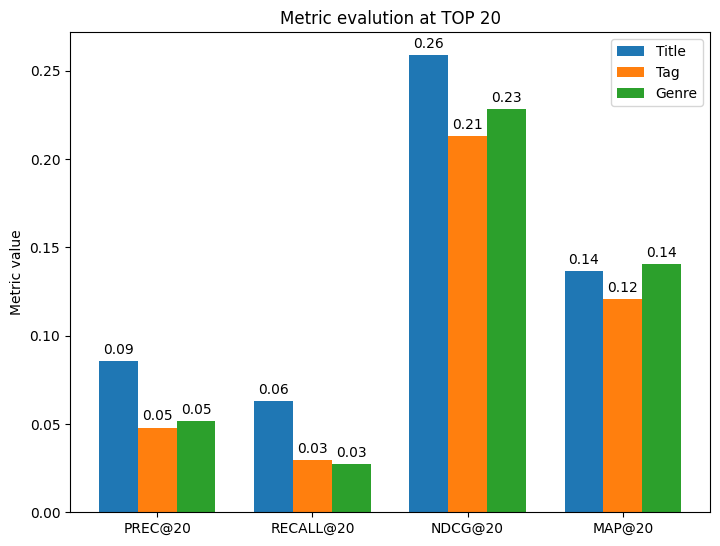

In [41]:
# x = ["PREC@10","PREC@20","PREC@50","RECALL@10","RECALL@20","RECALL@50","NDCG@10","NDCG@20","NDCG@50","MAP@10","MAP@20","MAP@50"]
labels = ["PREC@20","RECALL@20","NDCG@20","MAP@20"]
y1 = [0.085656,0.063036,0.258815,0.136731]
y2 = [0.047951,0.029481,0.213229,0.120592]
y3 = [0.051885,0.027308,0.228107,0.140758]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(x - 0.25, y1, width, label="Title")
rects2 = ax.bar(x, y2, width, label="Tag")
rects3 = ax.bar(x + 0.25, y3, width, label="Genre")

ax.set_ylabel("Metric value")
ax.set_title("Metric evalution at TOP 20")
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

plt.show()

The Title-based similarities are the best-performing, followed by Genre and then Tags.

The Tags in the ML 100k dataset are extremely sparsed, so for better evaluation the ML 27M dataset could be used.